# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=3,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 71)
OOV context shape: (16562, 28)
Right context shape: (16562, 79)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

dataset[0]

(tensor([ 2968, 10710,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,  1320,
          1320]),
 tensor([19, 31, 19, 32, 29, 19, 32, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 17, 17]),
 tensor([1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929,
         1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929,
         1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929, 1929,
         1929, 1929, 1929, 1929, 1929, 1929, 1929, 192

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
next(iter(dataloader))

[tensor([[4362, 6816, 9969,  ..., 1320, 1320, 1320],
         [4492, 1320, 1320,  ..., 1320, 1320, 1320],
         [3206, 1934, 1320,  ..., 1320, 1320, 1320],
         ...,
         [3040, 8109, 9930,  ..., 1320, 1320, 1320],
         [1320, 1320, 1320,  ..., 1320, 1320, 1320],
         [5214, 7481, 5879,  ..., 1320, 1320, 1320]]),
 tensor([[22, 27, 29, 33, 32, 38, 36, 27, 20, 39, 37, 27, 17, 17, 17, 17, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
         [34, 23, 31, 23, 25, 19, 32, 25, 18, 37, 19, 26, 19, 31, 17, 17, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
         [33, 24, 24, 37, 26, 33, 36, 23, 37, 17, 17, 17, 17, 17, 17, 17, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
         [36, 19, 31, 32, 19, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
         [38, 26, 19, 43, 27, 20, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
          17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
 

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.output = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
        
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        output = self.output(output)
        
        return output

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.output[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (output): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        probs = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(probs, actual_label.to(hyperparams.device))
        metric_score = metric(probs.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            print(f"Batch-{batch}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"Batch-{batch}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=6.5112 | F1Score=0.2656
Batch-100: NLLLoss=5.1616 | F1Score=0.2992
Batch-150: NLLLoss=3.6995 | F1Score=0.3184
Batch-200: NLLLoss=4.6128 | F1Score=0.3421
Batch-250: NLLLoss=4.2688 | F1Score=0.3643
Batch-300: NLLLoss=3.2373 | F1Score=0.3807
Batch-350: NLLLoss=3.6407 | F1Score=0.3974
Batch-400: NLLLoss=3.2223 | F1Score=0.4096
Batch-450: NLLLoss=3.8874 | F1Score=0.4200
Batch-500: NLLLoss=2.9598 | F1Score=0.4302
Batch-518: NLLLoss=3.1452 | F1Score=0.4343

Mean NLLLoss: 4.5292 | Mean F1Score: 0.3543

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=4.4317 | F1Score=0.5800
Batch-100: NLLLoss=2.3303 | F1Score=0.5888
Batch-150: NLLLoss=3.3227 | F1Score=0.5985
Batch-200: NLLLoss=3.1648 | F1Score=0.6006
Batch-250: NLLLoss=2.9206 | F1Score=0.6074
Batch-300: NLLLoss=1.7651 | F1Score=0.6154
Batch-350: NLLLoss=3.1596 | F1Score=0.6213
Batch-400: NLLLoss=2.1407 | F1Score=0.6260
Batch-450: NLLLoss=1.5940 | F1Score=0.6330
Batch-500: NLLLoss=1.7500 | F1Score=0.6371
Batch-518: NLLLoss=3.5263 | F1Score=0.6390

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7032 | Mean F1Score: 0.6096

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=2.2999 | F1Score=0.7287
Batch-100: NLLLoss=1.0417 | F1Score=0.7276
Batch-150: NLLLoss=1.8807 | F1Score=0.7322
Batch-200: NLLLoss=2.2639 | F1Score=0.7321
Batch-250: NLLLoss=1.3577 | F1Score=0.7350
Batch-300: NLLLoss=1.0038 | F1Score=0.7372
Batch-350: NLLLoss=1.9762 | F1Score=0.7402
Batch-400: NLLLoss=1.4470 | F1Score=0.7408
Batch-450: NLLLoss=2.0801 | F1Score=0.7446
Batch-500: NLLLoss=1.0879 | F1Score=0.7474
Batch-518: NLLLoss=1.1567 | F1Score=0.7479

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7656 | Mean F1Score: 0.7381

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=1.0073 | F1Score=0.8144
Batch-100: NLLLoss=1.6638 | F1Score=0.8175
Batch-150: NLLLoss=1.0466 | F1Score=0.8135
Batch-200: NLLLoss=1.2007 | F1Score=0.8116
Batch-250: NLLLoss=0.8748 | F1Score=0.8108
Batch-300: NLLLoss=1.4011 | F1Score=0.8116
Batch-350: NLLLoss=0.8771 | F1Score=0.8154
Batch-400: NLLLoss=0.8196 | F1Score=0.8175
Batch-450: NLLLoss=2.3856 | F1Score=0.8186
Batch-500: NLLLoss=1.2798 | F1Score=0.8206
Batch-518: NLLLoss=1.3580 | F1Score=0.8212

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1359 | Mean F1Score: 0.8156

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.7153 | F1Score=0.8956
Batch-100: NLLLoss=0.8405 | F1Score=0.8944
Batch-150: NLLLoss=0.5382 | F1Score=0.8933
Batch-200: NLLLoss=0.4849 | F1Score=0.8884
Batch-250: NLLLoss=1.1035 | F1Score=0.8841
Batch-300: NLLLoss=0.5632 | F1Score=0.8822
Batch-350: NLLLoss=0.7138 | F1Score=0.8810
Batch-400: NLLLoss=1.1949 | F1Score=0.8789
Batch-450: NLLLoss=0.5857 | F1Score=0.8785
Batch-500: NLLLoss=0.9457 | F1Score=0.8787
Batch-518: NLLLoss=0.3931 | F1Score=0.8784

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6696 | Mean F1Score: 0.8858

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.4096 | F1Score=0.9650
Batch-100: NLLLoss=0.0510 | F1Score=0.9633
Batch-150: NLLLoss=0.2052 | F1Score=0.9588
Batch-200: NLLLoss=0.3708 | F1Score=0.9556
Batch-250: NLLLoss=0.2859 | F1Score=0.9544
Batch-300: NLLLoss=0.5328 | F1Score=0.9520
Batch-350: NLLLoss=0.2539 | F1Score=0.9493
Batch-400: NLLLoss=0.4416 | F1Score=0.9487
Batch-450: NLLLoss=0.5912 | F1Score=0.9455
Batch-500: NLLLoss=0.3598 | F1Score=0.9441
Batch-518: NLLLoss=0.3752 | F1Score=0.9440

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3177 | Mean F1Score: 0.9541

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0968 | F1Score=0.9925
Batch-100: NLLLoss=0.0736 | F1Score=0.9936
Batch-150: NLLLoss=0.0604 | F1Score=0.9931
Batch-200: NLLLoss=0.0944 | F1Score=0.9925
Batch-250: NLLLoss=0.1230 | F1Score=0.9924
Batch-300: NLLLoss=0.1116 | F1Score=0.9918
Batch-350: NLLLoss=0.0399 | F1Score=0.9912
Batch-400: NLLLoss=0.0919 | F1Score=0.9910
Batch-450: NLLLoss=0.1053 | F1Score=0.9906
Batch-500: NLLLoss=0.0292 | F1Score=0.9901
Batch-518: NLLLoss=0.2066 | F1Score=0.9897

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1018 | Mean F1Score: 0.9922

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0236 | F1Score=1.0000
Batch-100: NLLLoss=0.0096 | F1Score=0.9997
Batch-150: NLLLoss=0.0229 | F1Score=0.9987
Batch-200: NLLLoss=0.0243 | F1Score=0.9989
Batch-250: NLLLoss=0.0213 | F1Score=0.9989
Batch-300: NLLLoss=0.0083 | F1Score=0.9987
Batch-350: NLLLoss=0.0176 | F1Score=0.9986
Batch-400: NLLLoss=0.0204 | F1Score=0.9986
Batch-450: NLLLoss=0.0085 | F1Score=0.9987
Batch-500: NLLLoss=0.0188 | F1Score=0.9986
Batch-518: NLLLoss=0.0294 | F1Score=0.9986

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0275 | Mean F1Score: 0.9990

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0119 | F1Score=1.0000
Batch-100: NLLLoss=0.0106 | F1Score=1.0000
Batch-150: NLLLoss=0.0072 | F1Score=1.0000
Batch-200: NLLLoss=0.1044 | F1Score=0.9998
Batch-250: NLLLoss=0.0048 | F1Score=0.9998
Batch-300: NLLLoss=0.0135 | F1Score=0.9997
Batch-350: NLLLoss=0.0089 | F1Score=0.9996
Batch-400: NLLLoss=0.0119 | F1Score=0.9995
Batch-450: NLLLoss=0.0047 | F1Score=0.9994
Batch-500: NLLLoss=0.0136 | F1Score=0.9994
Batch-518: NLLLoss=0.0066 | F1Score=0.9994

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0110 | Mean F1Score: 0.9997

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0027 | F1Score=1.0000
Batch-100: NLLLoss=0.0051 | F1Score=0.9994
Batch-150: NLLLoss=0.0073 | F1Score=0.9993
Batch-200: NLLLoss=0.0050 | F1Score=0.9991
Batch-250: NLLLoss=0.0051 | F1Score=0.9992
Batch-300: NLLLoss=0.0071 | F1Score=0.9993
Batch-350: NLLLoss=0.0033 | F1Score=0.9994
Batch-400: NLLLoss=0.0034 | F1Score=0.9994
Batch-450: NLLLoss=0.0077 | F1Score=0.9994
Batch-500: NLLLoss=0.0079 | F1Score=0.9994
Batch-518: NLLLoss=0.0105 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0081 | Mean F1Score: 0.9994

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0035 | F1Score=0.9994
Batch-100: NLLLoss=0.0018 | F1Score=0.9994
Batch-150: NLLLoss=0.0017 | F1Score=0.9996
Batch-200: NLLLoss=0.0037 | F1Score=0.9997
Batch-250: NLLLoss=0.0243 | F1Score=0.9994
Batch-300: NLLLoss=0.0064 | F1Score=0.9992
Batch-350: NLLLoss=0.0049 | F1Score=0.9993
Batch-400: NLLLoss=0.2547 | F1Score=0.9992
Batch-450: NLLLoss=0.0068 | F1Score=0.9993
Batch-500: NLLLoss=0.0108 | F1Score=0.9994
Batch-518: NLLLoss=0.0023 | F1Score=0.9994

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0075 | Mean F1Score: 0.9994

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0031 | F1Score=1.0000
Batch-100: NLLLoss=0.0017 | F1Score=0.9997
Batch-150: NLLLoss=0.0036 | F1Score=0.9994
Batch-200: NLLLoss=0.0025 | F1Score=0.9991
Batch-250: NLLLoss=0.0037 | F1Score=0.9992
Batch-300: NLLLoss=0.0031 | F1Score=0.9993
Batch-350: NLLLoss=0.0014 | F1Score=0.9994
Batch-400: NLLLoss=0.0043 | F1Score=0.9994
Batch-450: NLLLoss=0.0042 | F1Score=0.9994
Batch-500: NLLLoss=0.0021 | F1Score=0.9995
Batch-518: NLLLoss=0.0040 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0050 | Mean F1Score: 0.9995

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0023 | F1Score=0.9997
Batch-100: NLLLoss=0.0021 | F1Score=0.9998
Batch-150: NLLLoss=0.0021 | F1Score=0.9999
Batch-200: NLLLoss=0.0016 | F1Score=0.9998
Batch-250: NLLLoss=0.2145 | F1Score=0.9977
Batch-300: NLLLoss=0.1917 | F1Score=0.9809
Batch-350: NLLLoss=0.7681 | F1Score=0.9666
Batch-400: NLLLoss=0.0612 | F1Score=0.9591
Batch-450: NLLLoss=0.2453 | F1Score=0.9551
Batch-500: NLLLoss=0.0583 | F1Score=0.9535
Batch-518: NLLLoss=0.4078 | F1Score=0.9530

Huft 😥! Model not improved.
Mean NLLLoss: 0.1868 | Mean F1Score: 0.9824
Patience = 1/3❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0230 | F1Score=0.9650
Batch-100: NLLLoss=0.1375 | F1Score=0.9714
Batch-150: NLLLoss=0.0743 | F1Score=0.9718
Batch-200: NLLLoss=0.1390 | F1Score=0.9725
Batch-250: NLLLoss=0.1802 | F1Score=0.9736
Batch-300: NLLLoss=0.1057 | F1Score=0.9752
Batch-350: NLLLoss=0.1107 | F1Score=0.9770
Batch-400: NLLLoss=0.0210 | F1Score=0.9780
Batch-450: NLLLoss=0.0933 | F1Score=0.9785
Batch-500: NLLLoss=0.0209 | F1Score=0.9796
Batch-518: NLLLoss=0.0355 | F1Score=0.9797

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0875 | Mean F1Score: 0.9733

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0048 | F1Score=0.9987
Batch-100: NLLLoss=0.0019 | F1Score=0.9994
Batch-150: NLLLoss=0.0033 | F1Score=0.9996
Batch-200: NLLLoss=0.0031 | F1Score=0.9996
Batch-250: NLLLoss=0.0054 | F1Score=0.9994
Batch-300: NLLLoss=0.0046 | F1Score=0.9994
Batch-350: NLLLoss=0.0364 | F1Score=0.9994
Batch-400: NLLLoss=0.0032 | F1Score=0.9994
Batch-450: NLLLoss=0.0019 | F1Score=0.9992
Batch-500: NLLLoss=0.0025 | F1Score=0.9993
Batch-518: NLLLoss=0.0033 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0070 | Mean F1Score: 0.9992

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0024 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=1.0000
Batch-150: NLLLoss=0.0011 | F1Score=1.0000
Batch-200: NLLLoss=0.0014 | F1Score=0.9999
Batch-250: NLLLoss=0.0010 | F1Score=0.9999
Batch-300: NLLLoss=0.0008 | F1Score=0.9998
Batch-350: NLLLoss=0.0021 | F1Score=0.9999
Batch-400: NLLLoss=0.0014 | F1Score=0.9998
Batch-450: NLLLoss=0.0015 | F1Score=0.9998
Batch-500: NLLLoss=0.0012 | F1Score=0.9998
Batch-518: NLLLoss=0.0020 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0018 | Mean F1Score: 0.9999

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0009 | F1Score=1.0000
Batch-100: NLLLoss=0.0003 | F1Score=1.0000
Batch-150: NLLLoss=0.0012 | F1Score=1.0000
Batch-200: NLLLoss=0.0006 | F1Score=1.0000
Batch-250: NLLLoss=0.0009 | F1Score=1.0000
Batch-300: NLLLoss=0.0012 | F1Score=0.9999
Batch-350: NLLLoss=0.0013 | F1Score=0.9999
Batch-400: NLLLoss=0.0010 | F1Score=0.9997
Batch-450: NLLLoss=0.0016 | F1Score=0.9998
Batch-500: NLLLoss=0.0012 | F1Score=0.9997
Batch-518: NLLLoss=0.0012 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0018 | Mean F1Score: 0.9999
Patience = 2/3❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0009 | F1Score=0.9997
Batch-100: NLLLoss=0.0014 | F1Score=0.9998
Batch-150: NLLLoss=0.0009 | F1Score=0.9997
Batch-200: NLLLoss=0.0004 | F1Score=0.9995
Batch-250: NLLLoss=0.0009 | F1Score=0.9996
Batch-300: NLLLoss=0.0009 | F1Score=0.9996
Batch-350: NLLLoss=0.0008 | F1Score=0.9997
Batch-400: NLLLoss=0.0007 | F1Score=0.9997
Batch-450: NLLLoss=0.0005 | F1Score=0.9998
Batch-500: NLLLoss=0.0004 | F1Score=0.9997
Batch-518: NLLLoss=0.0009 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0017 | Mean F1Score: 0.9996

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50: NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0004 | F1Score=0.9998
Batch-150: NLLLoss=0.0005 | F1Score=0.9998
Batch-200: NLLLoss=0.0006 | F1Score=0.9998
Batch-250: NLLLoss=0.0004 | F1Score=0.9999
Batch-300: NLLLoss=0.0007 | F1Score=0.9999
Batch-350: NLLLoss=0.0005 | F1Score=0.9998
Batch-400: NLLLoss=0.0016 | F1Score=0.9998
Batch-450: NLLLoss=0.0009 | F1Score=0.9998
Batch-500: NLLLoss=0.0056 | F1Score=0.9998
Batch-518: NLLLoss=0.0015 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0020 | Mean F1Score: 0.9998
Patience = 3/3❗

Early stopping, patience = 3/3❗

TRAINING SUMMARY
Best NLLLoss : 0.0017
Best F1Score    : 0.9996
Training duration                   : 35.291 minutes.
Training date                       : 2022-09-27 17:35:31.710311+08:00


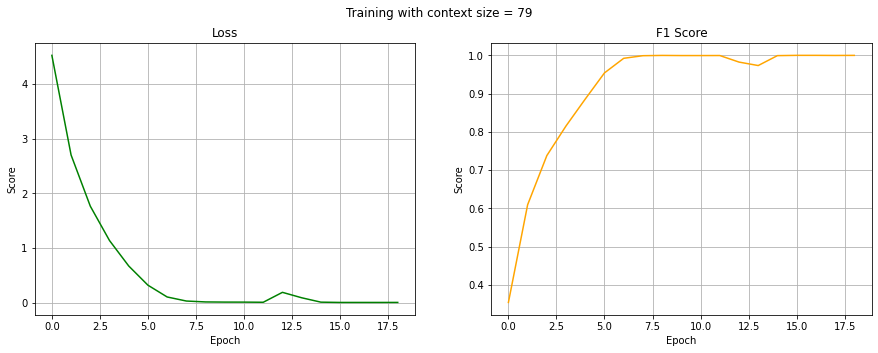

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n")
        f.write("TRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    print(f"Best {str(criterion).split('(')[0]} : {best_loss:.4f}")
    print(f"Best {str(metric).split('(')[0]}    : {best_metric:.4f}")
    print(f"Training duration                   : {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"Training date                       : {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"Best {str(criterion).split('(')[0]}\t\t\t: {best_loss:.4f}\n")
        f.write(f"Best {str(metric).split('(')[0]}\t\t\t: {best_metric:.4f}\n")
        f.write(f"Training duration\t\t: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"Training date\t\t\t: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_epoch_losses = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.pkl", "ab")
    filename_epoch_metric_scores = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.pkl", "ab")
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pickle.dump(epoch_losses, filename_epoch_losses)
    pickle.dump(epoch_metric_scores, filename_epoch_metric_scores)
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 0.97446734, -0.9207897 ,  2.5155778 , ...,  0.22350752,
         5.0463905 , -2.3612227 ],
       [-0.9812118 , -2.3189638 ,  2.5320249 , ...,  3.0968466 ,
         0.94626296,  4.1192956 ],
       [-2.4618566 , -0.872549  ,  3.7935877 , ...,  7.8122005 ,
         1.0972986 ,  5.756722  ],
       ...,
       [ 3.7515874 , -4.728428  , -1.6606576 , ..., -4.6594987 ,
         1.9444886 ,  5.0492134 ],
       [ 1.6343819 , -6.6216893 , -2.9922059 , ...,  6.0479054 ,
         4.1853447 ,  8.277634  ],
       [ 3.0201862 , -2.4644682 ,  3.8879626 , ...,  0.03129631,
         0.91845304,  5.135569  ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0909,  0.1268,  0.2140,  ..., -0.0709,  0.3129, -0.1070],
                      [ 0.2927, -0.1307, -0.0313,  ...,  0.0798, -0.1351, -0.0944],
                      [ 0.2948, -0.4045,  0.0444,  ..., -0.2641,  0.2353, -0.2198],
                      ...,
                      [-0.5211, -0.0447, -0.0391,  ...,  0.4550, -0.0113, -0.1194],
                      [ 0.1984, -0.5198,  0.1919,  ...,  0.1795,  0.1291, -0.0932],
                      [ 0.2624, -0.0323, -0.2265,  ..., -0.1058,  0.2666, -0.0230]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[ 0.0320,  0.2074,  0.0181,  ...,  0.0308, -0.0616,  0.1282],
                      [ 0.0264,  0.0562,  0.0781,  ...,  0.1096, -0.0245, -0.0299],
                      [ 0.1198,  0.0110,  0.1224,  ...,  0.0062, -0.0169,  0.1871],
                      ...,
                      [ 0.0115, -0.0160, -0.1295,  ...,  0.0086,  0.249